# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 라이브러리 버전을 확인해 봅니다
### 사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


#### 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### 2) 데이터로더 구성
##### load_data 안에서는 다음을 수행해야 합니다.

##### 데이터의 중복 제거
##### NaN 결측치 제거
##### 한국어 토크나이저로 토큰화
##### 불용어(Stopwords) 제거
##### 사전word_to_index 구성
##### 텍스트 스트링을 사전 인덱스 스트링으로 변환
##### X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000): 
    # 1. 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # 2. NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 3. 한국어 토크나이저로 토큰화 및 불용어 제거
    def tokenize_sentences(sentences):
        tokenized_sentences = []
        for sentence in sentences:
            # 토큰화 후 불용어 제거
            tokens = [word for word in tokenizer.morphs(sentence) if word not in stopwords]
            tokenized_sentences.append(tokens)
        return tokenized_sentences

    # 4. 훈련 데이터와 테스트 데이터 토큰화
    train_sentences = train_data['document'].tolist()
    test_sentences = test_data['document'].tolist()

    train_tokens = tokenize_sentences(train_sentences)
    test_tokens = tokenize_sentences(test_sentences)

    # 5. 단어 빈도수 계산
    all_tokens = [token for sentence in train_tokens for token in sentence]
    word_counts = Counter(all_tokens)
    
    # 6. 어휘 사전 생성 (빈도수 기준 상위 num_words 선택)
    vocab = [word for word, _ in word_counts.most_common(num_words - 4)]  # 상위 num_words-4개의 단어 선택
    word_to_index = {word: idx + 4 for idx, word in enumerate(vocab)}

    # 특수 토큰 추가 (패딩, 시작, 미확인 등)
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    word_to_index["<UNUSED>"] = 3

    # 7. 텍스트 데이터를 정수 인덱스 시퀀스로 변환
    def texts_to_sequences(tokens):
        sequences = []
        for sentence in tokens:
            sequence = [word_to_index.get(word, word_to_index["<UNK>"]) for word in sentence]
            sequences.append(sequence)
        return sequences

    X_train = texts_to_sequences(train_tokens)
    X_test = texts_to_sequences(test_tokens)

    # 8. 레이블을 numpy 배열로 변환
    y_train = np.array(train_data['label'].tolist())
    y_test = np.array(test_data['label'].tolist())

    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 3) 모델 구성을 위한 데이터 분석 및 가공


##### 데이터셋 내 문장 길이 분포
##### 적절한 최대 문장 길이 지정
##### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

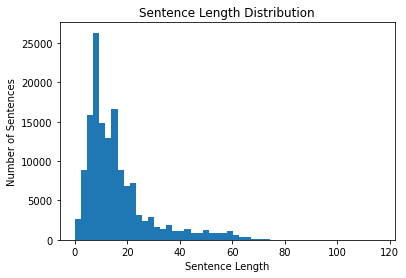

Max sentence length: 116
Mean sentence length: 15.98170773419436
Median sentence length: 12.0
Selected maximum sentence length: 33
X_train_padded shape: (146182, 33)
X_test_padded shape: (49157, 33)


In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 문장 길이 분포 분석
def analyze_sentence_length_distribution(X_data):
    sentence_lengths = [len(sentence) for sentence in X_data]

    plt.hist(sentence_lengths, bins=50)
    plt.xlabel('Sentence Length')
    plt.ylabel('Number of Sentences')
    plt.title('Sentence Length Distribution')
    plt.show()

    print(f"Max sentence length: {np.max(sentence_lengths)}")
    print(f"Mean sentence length: {np.mean(sentence_lengths)}")
    print(f"Median sentence length: {np.median(sentence_lengths)}")
    return sentence_lengths

# 1. 문장 길이 분포 분석
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
sentence_lengths = analyze_sentence_length_distribution(X_train)

# 2. 적절한 최대 문장 길이 지정
max_len = int(np.percentile(sentence_lengths, 90)) 

print(f"Selected maximum sentence length: {max_len}")

# 3. 패딩 추가
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')

print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")

#### 4) 모델 구성 및 validation set 구성
##### 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [7]:
# 1. CNN 모델

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential

X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')

vocab_size = 10000
word_vector_dim = 16
max_len = 100

def create_cnn_model():
    model = Sequential()
    model.add(Embedding(vocab_size, word_vector_dim, input_length=max_len))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [8]:
# 2. LSTM 모델

from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_lstm_model():
    model = Sequential()
    model.add(Embedding(vocab_size, word_vector_dim, input_length=max_len))
    model.add(LSTM(32))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model():
    embed_dim = 32
    num_heads = 2 
    ff_dim = 32 

    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(vocab_size, embed_dim, input_length=max_len)(inputs)

    # Add Transformer Encoder block
    transformer_block = TransformerEncoder(embed_dim, num_heads, ff_dim)
    x = transformer_block(embedding_layer)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

#### 5) 모델 훈련 개시

In [10]:
# 1. CNN

cnn_model = create_cnn_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

Epoch 1/10
1828/1828 - 9s - loss: 0.4303 - accuracy: 0.8058 - val_loss: 0.3488 - val_accuracy: 0.8487
Epoch 2/10
1828/1828 - 6s - loss: 0.3324 - accuracy: 0.8666 - val_loss: 0.3384 - val_accuracy: 0.8558
Epoch 3/10
1828/1828 - 6s - loss: 0.2909 - accuracy: 0.8883 - val_loss: 0.3459 - val_accuracy: 0.8529
Epoch 4/10
1828/1828 - 6s - loss: 0.2560 - accuracy: 0.9049 - val_loss: 0.3672 - val_accuracy: 0.8506
Epoch 5/10
1828/1828 - 6s - loss: 0.2198 - accuracy: 0.9206 - val_loss: 0.3960 - val_accuracy: 0.8517
Epoch 6/10
1828/1828 - 6s - loss: 0.1917 - accuracy: 0.9321 - val_loss: 0.4365 - val_accuracy: 0.8461
Epoch 7/10
1828/1828 - 6s - loss: 0.1638 - accuracy: 0.9437 - val_loss: 0.5063 - val_accuracy: 0.8392
Epoch 8/10
1828/1828 - 6s - loss: 0.1431 - accuracy: 0.9502 - val_loss: 0.5270 - val_accuracy: 0.8356
Epoch 9/10
1828/1828 - 6s - loss: 0.1251 - accuracy: 0.9564 - val_loss: 0.6472 - val_accuracy: 0.8346
Epoch 10/10
1828/1828 - 6s - loss: 0.1119 - accuracy: 0.9605 - val_loss: 0.6684 - 

In [11]:
# 2. LSTM

lstm_model = create_lstm_model()
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = lstm_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

'''
이 경고 메시지는 모델이 예측 또는 평가 시 사용된 입력 데이터의 shape이 
모델이 학습할 때 기대했던 입력 형태와 다르다는 것을 의미함.
결과의 정확도에 영향을 줄 수 있으나 그다지 치명적인 오류는 아니기에 넘어감.
'''

Epoch 1/10
1828/1828 - 10s - loss: 0.4363 - accuracy: 0.7948 - val_loss: 0.3611 - val_accuracy: 0.8395
Epoch 2/10
1828/1828 - 8s - loss: 0.3494 - accuracy: 0.8558 - val_loss: 0.3461 - val_accuracy: 0.8515
Epoch 3/10
1828/1828 - 8s - loss: 0.3236 - accuracy: 0.8672 - val_loss: 0.3432 - val_accuracy: 0.8511
Epoch 4/10
1828/1828 - 8s - loss: 0.3008 - accuracy: 0.8772 - val_loss: 0.3378 - val_accuracy: 0.8552
Epoch 5/10
1828/1828 - 8s - loss: 0.2775 - accuracy: 0.8885 - val_loss: 0.3610 - val_accuracy: 0.8559
Epoch 6/10
1828/1828 - 8s - loss: 0.2580 - accuracy: 0.8976 - val_loss: 0.3987 - val_accuracy: 0.8566
Epoch 7/10
1828/1828 - 8s - loss: 0.2419 - accuracy: 0.9048 - val_loss: 0.3909 - val_accuracy: 0.8547
Epoch 8/10
1828/1828 - 8s - loss: 0.2248 - accuracy: 0.9120 - val_loss: 0.4208 - val_accuracy: 0.8547
Epoch 9/10
1828/1828 - 8s - loss: 0.2118 - accuracy: 0.9178 - val_loss: 0.4519 - val_accuracy: 0.8525
Epoch 10/10
1828/1828 - 8s - loss: 0.1987 - accuracy: 0.9232 - val_loss: 0.4919 -

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')

transformer_model = create_transformer_model()
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_transformer = transformer_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

Epoch 1/10
1828/1828 - 13s - loss: 0.5744 - accuracy: 0.6568 - val_loss: 0.3711 - val_accuracy: 0.8377
Epoch 2/10
1828/1828 - 11s - loss: 0.3779 - accuracy: 0.8419 - val_loss: 0.3490 - val_accuracy: 0.8473
Epoch 3/10
1828/1828 - 11s - loss: 0.3407 - accuracy: 0.8563 - val_loss: 0.3738 - val_accuracy: 0.8453
Epoch 4/10
1828/1828 - 11s - loss: 0.3225 - accuracy: 0.8634 - val_loss: 0.3673 - val_accuracy: 0.8471
Epoch 5/10
1828/1828 - 11s - loss: 0.3099 - accuracy: 0.8666 - val_loss: 0.3834 - val_accuracy: 0.8419
Epoch 6/10
1828/1828 - 11s - loss: 0.3006 - accuracy: 0.8683 - val_loss: 0.4145 - val_accuracy: 0.8445
Epoch 7/10
1828/1828 - 11s - loss: 0.2917 - accuracy: 0.8705 - val_loss: 0.4497 - val_accuracy: 0.8424
Epoch 8/10
1828/1828 - 11s - loss: 0.2859 - accuracy: 0.8715 - val_loss: 0.4504 - val_accuracy: 0.8404
Epoch 9/10
1828/1828 - 11s - loss: 0.2794 - accuracy: 0.8741 - val_loss: 0.4568 - val_accuracy: 0.8408
Epoch 10/10
1828/1828 - 11s - loss: 0.2730 - accuracy: 0.8742 - val_loss:

#### 6) Loss, Accuracy 그래프 시각화

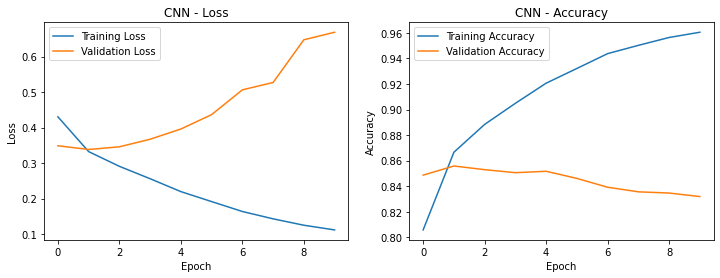

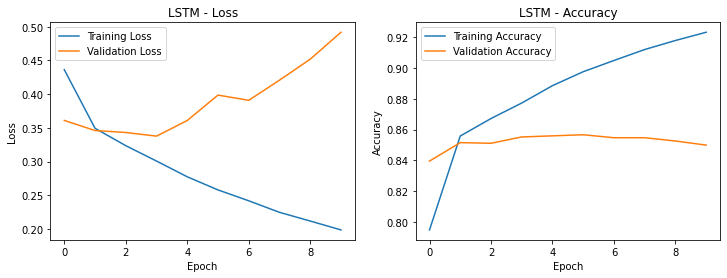

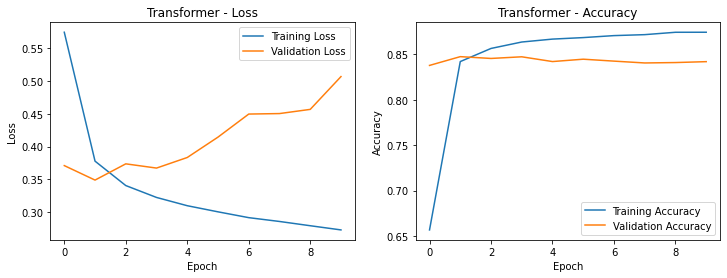

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# CNN 모델 학습 결과 시각화
plot_history(history_cnn, 'CNN')

# LSTM 모델 학습 결과 시각화
plot_history(history_lstm, 'LSTM')

# Transformer 모델 학습 결과 시각화
plot_history(history_transformer, 'Transformer')

#### 7) 학습된 Embedding 레이어 분석

In [15]:
# 1. 임베딩 레이어 가중치 추출 - 특정 단어의 벡터를 확인하거나 단어 간의 유사도 측정

import numpy as np

embedding_layer = cnn_model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(f"Embedding weights shape: {embedding_weights.shape}")

Embedding weights shape: (10000, 16)


In [16]:
# 2. 단어 벡터의 인덱스 매핑 확인

# word_to_index의 첫 10개 단어 확인
for word, index in list(word_to_index.items())[:10]:
    print(f"Word: {word}, Index: {index}")
    
# 특정 단어의 임베딩 벡터 확인
word = "영화"  # 예시 단어
word_index = word_to_index.get(word)

if word_index is not None:
    word_vector = embedding_weights[word_index]
    print(f"Embedding vector for '{word}':\n{word_vector}")
else:
    print(f"Word '{word}' not found in the vocabulary.")

Word: ., Index: 4
Word: 영화, Index: 5
Word: 다, Index: 6
Word: 고, Index: 7
Word: 하, Index: 8
Word: 을, Index: 9
Word: 보, Index: 10
Word: .., Index: 11
Word: 게, Index: 12
Word: ,, Index: 13
Embedding vector for '영화':
[-0.02844686 -0.01918484 -0.12054701 -0.17516147  0.03936895  0.05896856
 -0.0489966  -0.2966107   0.05104714  0.05143547 -0.06458221 -0.16174369
  0.06525192  0.09261276 -0.04731115 -0.00393619]


In [17]:
# 3. 단어 간의 유사도 측정 - 코사인 유사도를 통해 단어 간의 유사도를 측정
# Gensim의 유사 단어 찾기를 활용하여 자체 학습한 임베딩과 사전 학습 임베딩을 비교 분석 
# -> 자체 학습 임베딩의 유사 단어 찾기

from numpy import dot
from numpy.linalg import norm

# 코사인 유사도 계산 함수
def cosine_similarity(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# 단어와 가장 유사한 단어 찾기
def find_similar_words(target_word, word_to_index, embedding_weights, top_n=5):
    if target_word not in word_to_index:
        print(f"Word '{target_word}' not found in vocabulary.")
        return

    target_index = word_to_index[target_word]
    target_vector = embedding_weights[target_index]

    # 모든 단어와의 유사도 계산
    similarities = {}
    for word, index in word_to_index.items():
        if index == target_index:  # 자신과의 유사도는 계산하지 않음
            continue
        similarities[word] = cosine_similarity(target_vector, embedding_weights[index])

    # 유사도 순으로 정렬하여 상위 N개 단어 출력
    sorted_similar_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    for word, similarity in sorted_similar_words:
        print(f"Word: {word}, Similarity: {similarity:.4f}")

# '영화'와 유사한 단어 찾기
find_similar_words('영화', word_to_index, embedding_weights, top_n=5)

Word: ~, Similarity: 0.8340
Word: 터질, Similarity: 0.8072
Word: 고, Similarity: 0.8053
Word: 헐크, Similarity: 0.7944
Word: 우월, Similarity: 0.7702


#### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

##### 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
##### 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 

In [18]:
# 1. Word2Vec 임베딩 모델 불러오기
# Gensim의 유사 단어 찾기를 활용하여 자체 학습한 임베딩과 사전 학습 임베딩을 비교 분석 
# -> gensim 라이브러리를 사용해 사전에 학습된 Word2Vec 모델(word2vec_ko.model)을 불러옴

from gensim.models import Word2Vec

word2vec_file_path = 'data/word2vec_ko.model'
word2vec_model = Word2Vec.load(word2vec_file_path)

word_vector_dim = word2vec_model.wv.vector_size
print(f"Word2Vec vector size: {word_vector_dim}")

Word2Vec vector size: 100


In [19]:
# 2. Embedding 가중치 행렬 준비
# Gensim의 유사 단어 찾기를 활용하여 자체 학습한 임베딩과 사전 학습 임베딩을 비교 분석 
# -> 불러온 Word2Vec 모델을 활용하여 임베딩 가중치 행렬을 준비하는 부분

import numpy as np

vocab_size = len(word_to_index) 
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

for word, index in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[index] = word2vec_model.wv[word]
    else:
        embedding_matrix[index] = np.random.uniform(-0.01, 0.01, word_vector_dim)

In [20]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def create_cnn_model_with_word2vec():
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=word_vector_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))
    
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

cnn_model_word2vec = create_cnn_model_with_word2vec()
cnn_model_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn_word2vec = cnn_model_word2vec.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

Epoch 1/50
1828/1828 - 13s - loss: 0.6280 - accuracy: 0.6565 - val_loss: 0.5287 - val_accuracy: 0.7425
Epoch 2/50
1828/1828 - 10s - loss: 0.5371 - accuracy: 0.7393 - val_loss: 0.5073 - val_accuracy: 0.7717
Epoch 3/50
1828/1828 - 10s - loss: 0.5052 - accuracy: 0.7594 - val_loss: 0.4610 - val_accuracy: 0.7835
Epoch 4/50
1828/1828 - 10s - loss: 0.4866 - accuracy: 0.7710 - val_loss: 0.4498 - val_accuracy: 0.7905
Epoch 5/50
1828/1828 - 10s - loss: 0.4705 - accuracy: 0.7818 - val_loss: 0.4430 - val_accuracy: 0.8006
Epoch 6/50
1828/1828 - 10s - loss: 0.4592 - accuracy: 0.7877 - val_loss: 0.4353 - val_accuracy: 0.8032
Epoch 7/50
1828/1828 - 10s - loss: 0.4502 - accuracy: 0.7930 - val_loss: 0.4319 - val_accuracy: 0.8032
Epoch 8/50
1828/1828 - 10s - loss: 0.4416 - accuracy: 0.7979 - val_loss: 0.4231 - val_accuracy: 0.8069
Epoch 9/50
1828/1828 - 10s - loss: 0.4327 - accuracy: 0.8025 - val_loss: 0.4200 - val_accuracy: 0.8108
Epoch 10/50
1828/1828 - 10s - loss: 0.4287 - accuracy: 0.8045 - val_loss:

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_lstm_model_with_word2vec():
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=word_vector_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))
    
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.4)))
    model.add(BatchNormalization()) 
    
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.4)))
    model.add(BatchNormalization()) 
    
    model.add(LSTM(32, dropout=0.4))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

lstm_model_word2vec = create_lstm_model_with_word2vec()
lstm_model_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm_word2vec = lstm_model_word2vec.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Dropout, LayerNormalization, Input, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Sequential

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model_with_word2vec():
    embed_dim = word_vector_dim  
    num_heads = 8 
    ff_dim = 256  

    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )(inputs)

    x = TransformerEncoder(embed_dim, num_heads, ff_dim, rate=0.2)(embedding_layer)
    x = BatchNormalization()(x)
    x = TransformerEncoder(embed_dim, num_heads, ff_dim, rate=0.2)(x)
    x = BatchNormalization()(x)
    x = TransformerEncoder(embed_dim, num_heads, ff_dim, rate=0.2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

transformer_model_word2vec = create_transformer_model_with_word2vec()
transformer_model_word2vec.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                                   loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_transformer_word2vec = transformer_model_word2vec.fit(
    X_train_padded, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2
)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    # 손실(Loss) 그래프
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

# 정확도 그래프 그리기 함수
def plot_accuracy(history, model_name):
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plot_history(history_cnn_word2vec, 'CNN')

plt.subplot(2, 3, 4)
plot_accuracy(history_cnn_word2vec, 'CNN')

plt.subplot(2, 3, 2)
plot_history(history_lstm_word2vec, 'LSTM')

plt.subplot(2, 3, 5)
plot_accuracy(history_lstm_word2vec, 'LSTM')

plt.subplot(2, 3, 3)
plot_history(history_transformer_word2vec, 'Transformer')

plt.subplot(2, 3, 6)
plot_accuracy(history_transformer_word2vec, 'Transformer')

plt.tight_layout()
plt.show()